[Cross Validation]

- K-fold 교차검증
- StratifiedKFold: 층화 교차 검증
- 히트맵 시각화
- 클래스 분포를 위한 수정된 막대 그래프 시각화

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [15]:
data_path = '../data/'

train_df = pd.read_csv(data_path+'train.csv', index_col='id')
test_df = pd.read_csv(data_path+'test.csv', index_col='id')
submission_df = pd.read_csv(data_path+'sample_submission.csv', index_col='id')

In [16]:
train_df.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [20]:
# train_df DataFrame에서 특징 변수들과 타겟 변수를 분리하여 X와 y에 각각 저장
X = train_df.drop(columns='defects')
y = train_df['defects'].astype(int)

In [18]:
# XGBoost 라이브러리의 분류기 초기화
# 트리 기반의 부스팅 방식을 사용
# 이진 분류를 위한 로지스틱 회귀 목적 함수를 가진 XGBoost 분류기를 model 변수에 초기화
model = XGBClassifier(booster='gbtree', objective='binary:logistic')

< K-fold 교차검증 >
- 5fold cross validation

In [21]:
# 모델 성능을 교차 검증을 통해 평가
# cv=5로 지정하여 5-fold 교차 검증 수행
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
roc_auc_scores = np.round(scores, 4)
roc_auc_mean = scores.mean()
roc_auc_std = scores.std()

print(f'roc auc : {roc_auc_scores}')
print(f'roc auc mean : {roc_auc_mean:.4f}')
print(f'roc auc std : {roc_auc_std:.4f}')

#결과해석: 5-fold 교차 검증을 통해 평균 roc auc 점수가 0.5를 넘었으므로 모델이 데이터를 잘 분류한다고 할 수 있음 -> 성능 개선 필요

roc auc : [0.7873 0.7823 0.7859 0.7842 0.7821]
roc auc mean : 0.7844
roc auc std : 0.0020


< StratifiedKFold: 층화 교차 검증>

In [22]:
from sklearn.model_selection import StratifiedKFold

# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=61)
kfold = StratifiedKFold(n_splits=5) #, shuffle=True, random_state=61)
scores = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc')
print(f'roc auc : {np.round(scores, 4)}')
print(f'roc auc mean : {scores.mean()}')

roc auc : [0.7873 0.7823 0.7859 0.7842 0.7821]
roc auc mean : 0.7843505344898614


In [45]:
# from sklearn.model_selection import StratifiedKFold

# # Define feature matrix and target vector
# X = train_df.drop(columns=['defects', 'id']) 
# y = train_df['defects']

# # Initialize StratifiedKFold
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=61)

# # Print the class distribution for the whole dataset and for each fold
# print(f'전체 데이터의 클래스 분포 : {np.bincount(y.astype(int))}')
# for idx, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
#     print(f'{idx+1}번째 훈련 폴드 : {np.bincount(y.iloc[train_idx].astype(int))}')
#     print(f'{idx+1}번째 검증 폴드 : {np.bincount(y.iloc[valid_idx].astype(int))}', end=f"\n{'-'*30}\n")


< 히트맵 시각화 >

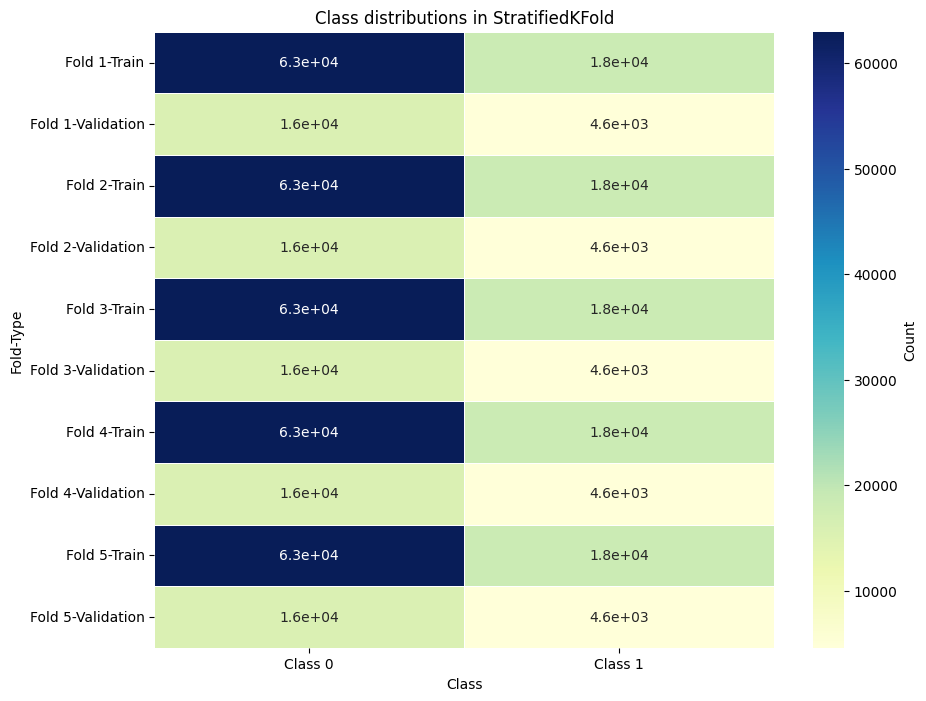

In [54]:
# heatmap visualization
heatmap_data = pd.DataFrame({
    'Class': [f'Class {i}' for i in range(len(train_distributions[0]))] * n_splits * 2,
    'Count': [item for sublist in train_distributions + valid_distributions for item in sublist],
    'Type': ['Train'] * n_splits * len(train_distributions[0]) + ['Validation'] * n_splits * len(valid_distributions[0]),
    'Fold': sum([[f'Fold {i+1}'] * len(train_distributions[0]) for i in range(n_splits)], []) * 2
})

# Plot heatmap
plt.figure(figsize=(10, 8))
pivot_table = heatmap_data.pivot_table(index=['Fold', 'Type'], columns='Class', values='Count')
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", linewidths=.5, cbar_kws={'label': 'Count'})
plt.title('Class distributions in StratifiedKFold')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

train_distributions = []
valid_distributions = []

for train_idx, valid_idx in kfold.split(X, y):
    train_distributions.append(np.bincount(y.iloc[train_idx].astype(int)))
    valid_distributions.append(np.bincount(y.iloc[valid_idx].astype(int)))

# Plotting
n_splits = kfold.get_n_splits()
bar_width = 0.35
index = np.arange(n_splits)

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(n_splits):
    ax.bar(index + i * bar_width, train_distributions[i], width=bar_width, label=f'Train Fold {i+1}')
    ax.bar(index + i * bar_width, valid_distributions[i], bottom=train_distributions[i], width=bar_width, label=f'Valid Fold {i+1}', alpha=0.6)

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class distributions in StratifiedKFold')
ax.set_xticks(index + bar_width * (n_splits / 2))
ax.set_xticklabels([str(i) for i in range(len(train_distributions[0]))])
ax.legend()

plt.tight_layout()
plt.show()


< 클래스 분포를 위한 수정된 막대 그래프 시각화 >

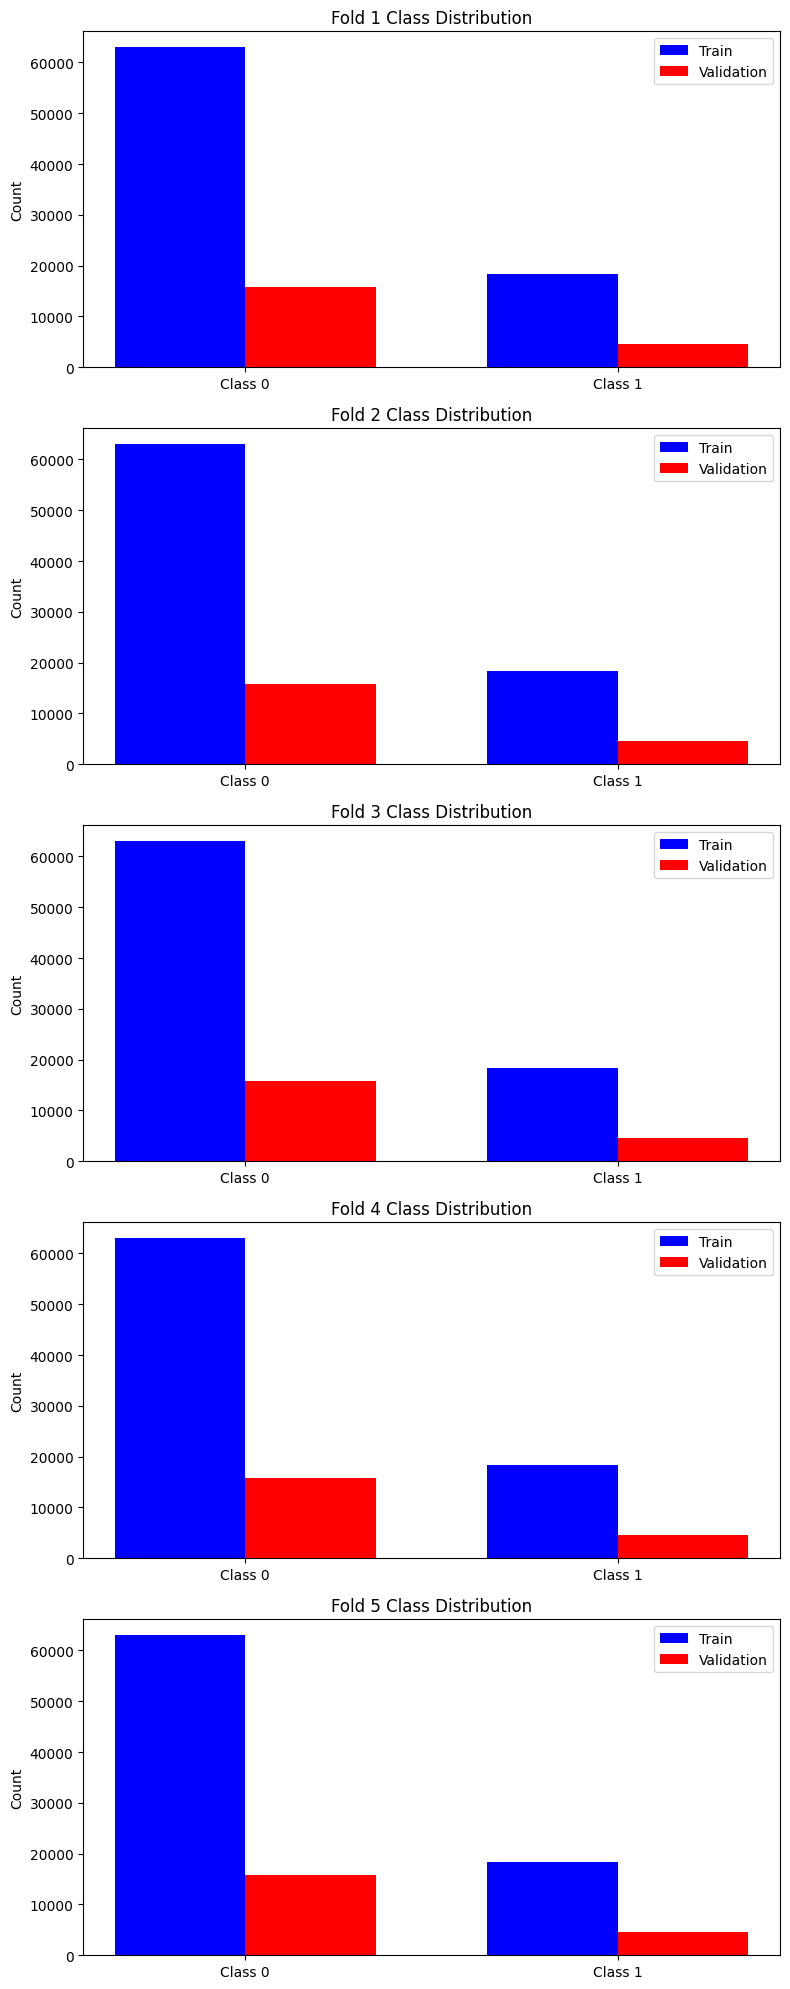

In [51]:
# Adjusted visualization with bar plots
fig, axes = plt.subplots(n_splits, 1, figsize=(8, 4 * n_splits))

for i, (train, valid) in enumerate(zip(train_distributions, valid_distributions)):
    ax = axes[i]
    bar_positions = np.arange(len(train))
    ax.bar(bar_positions - bar_width/2, train, width=bar_width, label='Train', color='blue')
    ax.bar(bar_positions + bar_width/2, valid, width=bar_width, label='Validation', color='red')
    
    ax.set_title(f'Fold {i+1} Class Distribution')
    ax.set_xticks(bar_positions)
    ax.set_xticklabels([f'Class {j}' for j in range(len(train))])
    ax.set_ylabel('Count')
    ax.legend()

plt.tight_layout()
plt.show()
